# Introduction

#### Scenario
A group of friends decide to travel to Toronto for their vacation and want to have only Italian or Chinese cuisine when they visit, so they would like to stay in a neighborhood with a high density of Italian or Chinese restaurants.

#### Business Problem:
The problem this project aims to solve is to  list and visualize all major parts of Toronto that has amazing Italian or Chinese restaurants.

#### Interested Audience
This would be a relevant challenge for anyone looking for a specific kind of cuisine when visting Toronto or any other city. This case is also applicable for anyone interested in exploring starting or locating a Restaurants in any city. 

# Data Section

#### Data Required
Collect the Toronto city data.
GeoSpace data to visualize the neighborhoods and form a list of Boroughs, Neighborhoods along with their map coordinates. 
A list of venues with Italian or Chinese food in each neighborhood of the city

#### Approach
Collect and clean the data from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. 
Form a data frame with Boroughs, Neighborhoods along with latitude and longitude using https://cocl.us/Geospatial_data. 
Use the FourSquareAPI to find all the Italian or Chinese restaurants. Rank the restaurants based on the ratings, like count and tips provided by the FourSquareAPI. Use folium to visualize the ranking of neighborhoods for the given criteria and draw insights to select a neigbourhood for the friends to stay in.

### Importing libraries

In [46]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#!pip install folium
import folium

### Create and clean the data frame for Toronto city

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
doc = requests.get(url).text
soup = BeautifulSoup(doc, 'html.parser')

table = soup.find('tbody')
rows = table.select('tr')
row = [r.get_text() for r in rows]
df = pd.DataFrame(row)
df = df[0].str.split('\n',expand = True)
df = df.rename(columns = df[0] )
df.columns = df.iloc[0]
df = df.drop(index = 0)
df = df[df.Borough!='Not assigned']
df.loc[df.Neighborhood == 'Not assigned', 'Neighborhood']  = df['Borough']
df = df.groupby(['Postal Code', 'Borough'], sort = False).agg(','.join)
df.reset_index(inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Visualize the data

(103, 3)


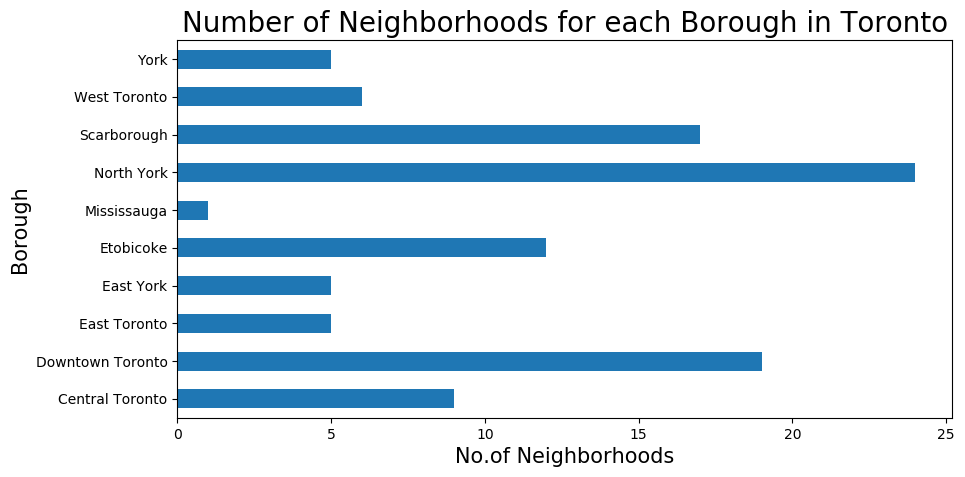

In [135]:
print(df.shape)
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Neighborhoods for each Borough in Toronto',fontsize=20)
plt.ylabel('Borough', fontsize = 15)
plt.xlabel('No.of Neighborhoods', fontsize=15)
df.groupby('Borough')['Neighborhood'].count().plot(kind='barh')
plt.show()

North York has the most number of neighborhoods (24 neighborhoods)


Mississauga has the least number of neighborhoods (1 neighborhood)

### Create GeoSpace dataframe

In [6]:
geourl = 'https://cocl.us/Geospatial_data'
geodata = pd.read_csv(geourl)
geodata.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Create Toronto dataframe with Boroughs, Neighborhoods, Latitudes and Longitudes

In [7]:
toronto_df = pd.merge(df, geodata, on = 'Postal Code')
toronto_df.drop('Postal Code', axis =1, inplace = True)
toronto_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Getting latitude and longitude of Toronto

In [8]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Use folium to visulize the neighborhoods

In [54]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, Neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### FourSquare API Details

In [184]:
CLIENT_ID = 'CPJQDUVBZNDEWN3QV0BQ0N2GSWKKPOBNIEHPR0QE5PNULOXQ' # your Foursquare ID
CLIENT_SECRET = 'UJC41OEBQQCKYHYYBOURJXTHCFHJU1G5Q0RQ0REFJXZ2JHU1' # your Foursquare Secret
VERSION = '20191225' # Foursquare API version

### Define function to get like count, tips, ratings etc for ranking the restaurants

In [178]:
def get_venue_details(venue_id):

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_details=[]
    try:
        venue_data=results['response']['venue']
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Define a function to get venue name, category and id

This function uses the explore FourSquare API and gets the top 100 venue name, category and id within a 1 km radius

In [179]:
def get_venues(lat,lng,radius=1000,LIMIT=100):
   
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Get Italian and Chinese Restaurants in the neighborhood

In [76]:
toronto_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [101]:
toronto_df.shape

(103, 4)

In [105]:
col_names = ['Borough', 'Neighborhood', 'ID','Name']
ita_rest = pd.DataFrame(columns=col_names)
chi_rest = pd.DataFrame(columns=col_names)
count = 0
for row in toronto_df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ita_resturants = venues[venues['Category']=='Italian Restaurant']  
    chi_resturants = venues[venues['Category']=='Chinese Restaurant']  
    print('Number of Italian and Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(ita_resturants)+len(chi_resturants)))
    for resturant_detail in ita_resturants.values.tolist():   
        id, name , category=resturant_detail
        ita_rest = ita_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    for resturant_detail in chi_resturants.values.tolist(): 
        id, name , category=resturant_detail
        chi_rest = chi_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
       

Number of Italian and Chinese Resturants in Parkwoods, North York:1
Number of Italian and Chinese Resturants in Victoria Village, North York:0
Number of Italian and Chinese Resturants in Regent Park, Harbourfront, Downtown Toronto:3
Number of Italian and Chinese Resturants in Lawrence Manor, Lawrence Heights, North York:0
Number of Italian and Chinese Resturants in Queen's Park, Ontario Provincial Government, Downtown Toronto:3
Number of Italian and Chinese Resturants in Islington Avenue, Humber Valley Village, Etobicoke:0
Number of Italian and Chinese Resturants in Malvern, Rouge, Scarborough:1
Number of Italian and Chinese Resturants in Don Mills, North York:0
Number of Italian and Chinese Resturants in Parkview Hill, Woodbine Gardens, East York:0
Number of Italian and Chinese Resturants in Garden District, Ryerson, Downtown Toronto:4
Number of Italian and Chinese Resturants in Glencairn, North York:1
Number of Italian and Chinese Resturants in West Deane Park, Princess Gardens, Mart

In [112]:
ita_rest.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,"Regent Park, Harbourfront",4ad776eef964a520e20a21e3,Mangia and Bevi Resto-Bar
1,Downtown Toronto,"Regent Park, Harbourfront",4cbdc6784495721ea262617a,Fusaro's
2,Downtown Toronto,"Regent Park, Harbourfront",56d8dff7498eb4e5e661e78d,Ardo
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4a8355bff964a520d3fa1fe3,Mercatto
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar


In [118]:
chi_rest.head()

,Borough,Neighborhood,ID,Name
0,North York,Parkwoods,4c0150f4716bc9b65b9dbb55,Spicy Chicken House
1,Scarborough,"Malvern, Rouge",4c706524df6b8cfab244b84d,Charley's Exotic Cuisine
2,North York,Don Mills,4b632004f964a520d6642ae3,Congee Star 帝王名粥
3,Scarborough,Woburn,4b64765ff964a52028b52ae3,Lucky Hakka
4,Downtown Toronto,Christie,53bd9f52498e6187cb7c185a,Chinese Dumpling House 中华饺子楼


####  Italian and Chinese Restaurants dataframe

In [117]:
ita_chi_rest = ita_rest.append(chi_rest,ignore_index=True)

,Borough,Neighborhood,ID,Name
160,Scarborough,"Steeles West, L'Amoreaux West",4df28ea0e4cda09e6da0129a,Mr Congee Chinese Cuisine 龍粥記
161,Scarborough,"Steeles West, L'Amoreaux West",5542be72498e851f264ce89a,Phoenix Restaurant 金鳳餐廳
162,Scarborough,"Steeles West, L'Amoreaux West",4b2677d0f964a520f37b24e3,Divine Wok Restaurant
163,Scarborough,"Steeles West, L'Amoreaux West",52921e1911d20de918efdb0a,Buddy Cafe
164,Scarborough,"Steeles West, L'Amoreaux West",56673b22498e2d33ad4b7325,Dumpling & Szechuan Cuisine（川流不息店）


In [149]:
ita_chi_rest.shape

(165, 4)

So 165 restaurants serve Italian or Chinese food

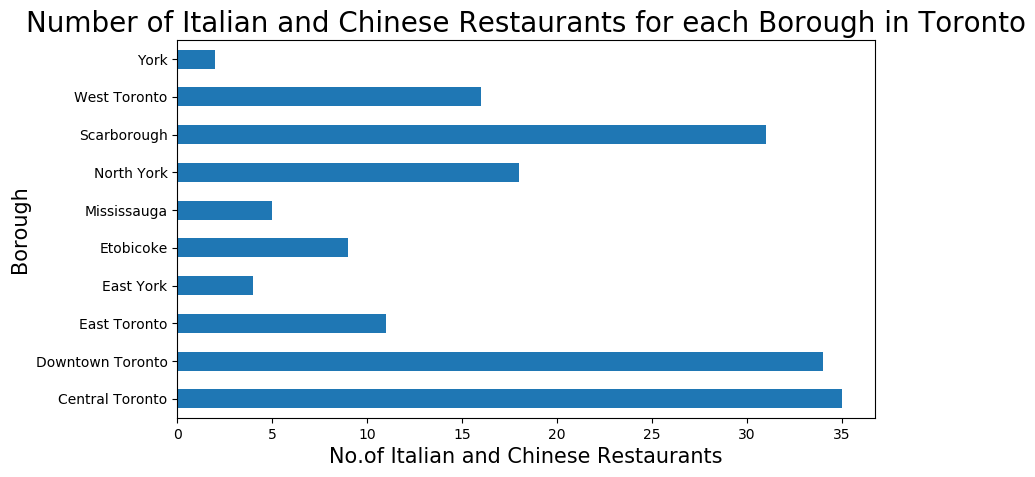

In [136]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Italian and Chinese Restaurants for each Borough in Toronto',fontsize=20)
plt.ylabel('Borough', fontsize = 15)
plt.xlabel('No.of Italian and Chinese Restaurants', fontsize=15)
ita_chi_rest.groupby('Borough')['ID'].count().plot(kind='barh')
plt.show()

The neighborhood with the most amount of italian and chinese restaurants is Central Toronto with 35 restaurants.
The neighborhood with the least amount of italian and chinese restaurants is York with 2 restaurants.

### Rank the Restaurants

In [185]:
col_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ita_chi_rest_rank=pd.DataFrame(columns=col_names)
count = 0

for row in ita_chi_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ita_chi_rest),')','processed')
    ita_chi_rest_rank = ita_chi_rest_rank.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
    if count == 50 :
        print("Limit Exceeded")
        break

print ("Fully Processed")

                         ID                       Name  Likes  Rating  Tips
0  4ad776eef964a520e20a21e3  Mangia and Bevi Resto-Bar     77     8.4    40
                         ID      Name  Likes  Rating  Tips
0  4cbdc6784495721ea262617a  Fusaro's     57     8.7    22
                         ID  Name  Likes  Rating  Tips
0  56d8dff7498eb4e5e661e78d  Ardo     15     7.8     8
                         ID      Name  Likes  Rating  Tips
0  4a8355bff964a520d3fa1fe3  Mercatto     56     8.1    26
                         ID                              Name  Likes  Rating  \
0  52f6816f11d24a43115dc834  Scaddabush Italian Kitchen & Bar    171     7.9   

   Tips  
0    70  
                         ID               Name  Likes  Rating  Tips
0  4af30f13f964a52030ea21e3  Trattoria Nervosa    204     8.7    82
                         ID                              Name  Likes  Rating  \
0  52f6816f11d24a43115dc834  Scaddabush Italian Kitchen & Bar    171     7.9   

   Tips  
0    70  
    

We will get only a limted amount of ratings since the Foursquare API allows only a restricted number of calls per day for the free account

In [192]:
ita_chi_rest_rank.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Regent Park, Harbourfront",4ad776eef964a520e20a21e3,Mangia and Bevi Resto-Bar,77,8.4,40
1,Downtown Toronto,"Regent Park, Harbourfront",4cbdc6784495721ea262617a,Fusaro's,57,8.7,22
2,Downtown Toronto,"Regent Park, Harbourfront",56d8dff7498eb4e5e661e78d,Ardo,15,7.8,8
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4a8355bff964a520d3fa1fe3,Mercatto,56,8.1,26
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",52f6816f11d24a43115dc834,Scaddabush Italian Kitchen & Bar,171,7.9,70


In [193]:
ita_chi_rest_rank.to_csv('ita_chi_rest_rank.csv', index=False)

In [194]:
ita_chi_rest_rank.shape

(165, 7)

Convert the likes and tips count to float

In [196]:
ita_chi_rest_rank['Likes']=ita_chi_rest_rank['Likes'].astype('float64')
ita_chi_rest_rank['Tips']=ita_chi_rest_rank['Tips'].astype('float64')

In [201]:
ne = ita_chi_rest_rank[ita_chi_rest_rank.Tips != 0]
ne.shape

(45, 7)